<a href="https://colab.research.google.com/github/tahseen-Ahmed01/machine-learning-projects/blob/main/Dataset_BUSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Dataset_BUSI_with_GT

Mounted at /content/drive
/content/drive/MyDrive/Dataset_BUSI_with_GT


# Installations


In [ ]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.0
    Uninstalling tensorflow-2.17.0:
      Successfully uninstalled tensorflow-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompat

# Imports

In [20]:
import os
import re
import shutil
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
# Define the dataset path
dataset_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset'

In [8]:
# Define the base dataset path
dataset_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset'

# Define the categories
categories = ['benign', 'malignant', 'normal']

for category in categories:
    category_path = os.path.join(dataset_path, category)

    # Create the main category folder if it doesn't exist
    if not os.path.exists(category_path):
        os.makedirs(category_path)

    # Create destination and masked folders
    destination_target_dir = os.path.join(category_path, category)  # Original images
    masked_target_dir = os.path.join(category_path, 'masked')       # Masked images

    os.makedirs(destination_target_dir, exist_ok=True)  # Create if it doesn't exist
    os.makedirs(masked_target_dir, exist_ok=True)        # Create if it doesn't exist

    # Move files to the respective folders
    for filename in os.listdir(category_path):
        if filename.endswith('.png'):
            if '_mask' in filename:
                # Move to masked folder
                shutil.move(os.path.join(category_path, filename), os.path.join(masked_target_dir, filename))
            else:
                # Move to benign/malignant/normal folder
                shutil.move(os.path.join(category_path, filename), os.path.join(destination_target_dir, filename))

print("All files moved successfully.")


All files moved successfully.


# Rename the images (remove extra spaces and brackets)

In [9]:
# Function to rename images and masks
def rename_files_in_category(category):
    # Define paths for images and masks
    image_folder = os.path.join(dataset_path, category, category)
    mask_folder = os.path.join(dataset_path, category, 'masked')

    # Rename images
    for filename in os.listdir(image_folder):
        match = re.match(rf'{category} \((\d+)\)\.png', filename)
        if match:
            number = match.group(1)
            new_filename = f'{category}_{number}.png'
            old_file_path = os.path.join(image_folder, filename)
            new_file_path = os.path.join(image_folder, new_filename)
            os.rename(old_file_path, new_file_path)
            # print(f'Renamed image: {old_file_path} to {new_file_path}')

    # Rename masks
    for filename in os.listdir(mask_folder):
        match = re.match(rf'{category} \((\d+)\)_mask\.png', filename)
        if match:
            number = match.group(1)
            new_filename = f'{category}_{number}_mask.png'
            old_file_path = os.path.join(mask_folder, filename)
            new_file_path = os.path.join(mask_folder, new_filename)
            os.rename(old_file_path, new_file_path)
            # print(f'Renamed mask: {old_file_path} to {new_file_path}')

# Categories to process
categories = ['benign', 'malignant', 'normal']

# Process each category
for category in categories:
    rename_files_in_category(category)
print("All Files are renamed successfully")


All Files are renamed successfully


# Normalise the dataset

In [10]:
# Define ImageDataGenerator with normalization
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values
    rotation_range=30,  # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift the image horizontally
    height_shift_range=0.2,  # Randomly shift the image vertically
    shear_range=0.2,  # Shear angle in a counter-clockwise direction
    zoom_range=0.2,  # Randomly zoom the image
    horizontal_flip=True,  # Randomly flip images
    fill_mode='nearest'  # Fill missing pixels after transformation
)

# Train your model using the normalized dataset
train_generator = datagen.flow_from_directory('/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset', target_size=(256, 256), batch_size=32, class_mode='binary')


Found 1588 images belonging to 3 classes.


# Annotate your images for YOLO

In [15]:
def convert_mask_to_yolo(mask_path, class_id, img_width, img_height, output_txt):
    # Ensure the directory for the output file exists
    os.makedirs(os.path.dirname(output_txt), exist_ok=True)

    # Read the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        raise FileNotFoundError(f"Mask image not found: {mask_path}")

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    with open(output_txt, 'w') as file:
        # For each contour (each object)
        for contour in contours:
            # Get the bounding box for the contour
            x, y, w, h = cv2.boundingRect(contour)

            # Convert to YOLO format
            x_center = (x + w / 2) / img_width
            y_center = (y + h / 2) / img_height
            width = w / img_width
            height = h / img_height

            # Write the class_id and bounding box to the output file
            file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")
    # print("Mask shape:", mask.shape)

In [16]:
# Define dataset paths
dataset_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset'
class_ids = {
    "normal": 0,
    "benign": 1,
    "malignant": 2
}

# Iterate over each class folder
# Iterate over each class folder
for class_name, class_id in class_ids.items():
    class_folder = os.path.join(dataset_path, class_name)
    masked_folder = os.path.join(class_folder, "masked")

    # Create labels folder if it doesn't exist
    os.makedirs(os.path.join(class_folder, "labels"), exist_ok=True)

    # Iterate over all mask files in the masked folder
    for mask_file in os.listdir(masked_folder):
        if mask_file.endswith("_mask.png"):
            mask_path = os.path.join(masked_folder, mask_file)
            # Output file name can be based on mask file name
            output_txt = os.path.join(class_folder, "labels", f"{mask_file[:-9]}.txt")  # Strip the '_mask' part

            # Call the conversion function
            convert_mask_to_yolo(mask_path, class_id, 1024, 768, output_txt)

# Display the bounded region on original image

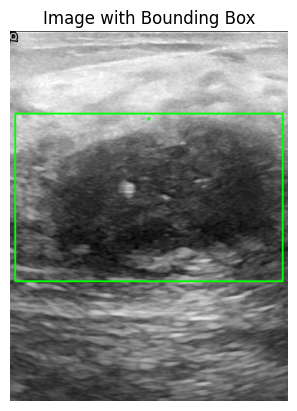

Bounding Box Dimensions (Width, Height): [(1, 1), (1, 1), (432, 271)]


In [36]:
def draw_bounding_box(image_path, txt_file, img_width, img_height):
    # Load the original image
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found")
        return
    dimensions = []
    # Read YOLO format annotations from the txt file
    with open(txt_file, 'r') as file:
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())

            # Convert normalized YOLO coordinates back to pixel values
            x_center_pixel = x_center * img_width
            y_center_pixel = y_center * img_height
            box_width_pixel = width * img_width
            box_height_pixel = height * img_height

            # Calculate the bounding box corners
            x_min = int(x_center_pixel - (box_width_pixel / 2))
            y_min = int(y_center_pixel - (box_height_pixel / 2))
            x_max = int(x_center_pixel + (box_width_pixel / 2))
            y_max = int(y_center_pixel + (box_height_pixel / 2))

            # Draw the bounding box on the image
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green box
             # Calculate width and height
            bbox_width = x_max - x_min
            bbox_height = y_max - y_min
            dimensions.append((bbox_width, bbox_height))


    # Convert the image to RGB (since OpenCV uses BGR by default)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with bounding box
    plt.imshow(img_rgb)
    plt.title("Image with Bounding Box")
    plt.axis('off')  # Hide axis
    plt.show()

    return dimensions

# Example usage
image_path = '/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/malignant/malignant/malignant_1.png'
txt_file = '/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/malignant/labels/malignant_1.txt'
img_width = 1024  # Actual image width
img_height = 768  # Actual image height

#draw_bounding_box(image_path, txt_file, img_width, img_height)
bounding_box_dimensions = draw_bounding_box(image_path, txt_file, img_width, img_height)
print("Bounding Box Dimensions (Width, Height):", bounding_box_dimensions)

# Split the dataset

In [17]:
# Define paths
dataset_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset'  # Update with your dataset directory
output_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset'    # Update with your desired output directory

# Define class folders
classes = ['benign', 'malignant', 'normal']

# Create output directories for train, test, and val splits
for split in ['train', 'test', 'val']:
    for cls in classes:
        os.makedirs(os.path.join(output_dir, split, cls, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, split, cls, 'labels'), exist_ok=True)

# Function to split and copy data
def split_and_copy_data(class_folder):
    # Paths for images and masks
    images_folder_path = os.path.join(dataset_dir, class_folder, 'benign' if class_folder == 'benign' else class_folder)
    labels_folder_path = os.path.join(dataset_dir, class_folder, 'labels')  # Assuming labels are in 'labels' folder

    # Check if folders exist
    if not os.path.exists(images_folder_path):
        print(f"Images folder not found: {images_folder_path}")
        return
    if not os.path.exists(labels_folder_path):
        print(f"Labels folder not found: {labels_folder_path}")
        return

    # List of image and label files
    image_filenames = os.listdir(images_folder_path)
    label_filenames = os.listdir(labels_folder_path)

    # Split data into train (80%), temp (20%: test + val)
    train_files, temp_files = train_test_split(image_filenames, test_size=0.2, random_state=42)  # 80% train, 20% temp
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)  # Split temp into 10% val and 10% test

    # Function to copy files to respective split folders
    def copy_files(files, split):
        for file in files:
            src_image_path = os.path.join(images_folder_path, file)
            dst_image_path = os.path.join(output_dir, split, class_folder, 'images', file)
            shutil.copy(src_image_path, dst_image_path)

            # Copy corresponding label file
            label_file = file[:-4] + '.txt'  # Assuming labels have the same base name as images
            src_label_path = os.path.join(labels_folder_path, label_file)
            dst_label_path = os.path.join(output_dir, split, class_folder, 'labels', label_file)

            # Check if the label file exists before copying
            if os.path.exists(src_label_path):
                shutil.copy(src_label_path, dst_label_path)
            else:
                print(f"Label file not found: {src_label_path}")

    # Copy files to train, test, and val folders
    copy_files(train_files, 'train')
    copy_files(test_files, 'test')
    copy_files(val_files, 'val')

# Loop through each class and split the data
for cls in classes:
    split_and_copy_data(cls)

print("Dataset split and organized successfully.")


Label file not found: /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/benign/labels/benign_198.txt
Label file not found: /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/benign/labels/benign (200) (1).txt
Label file not found: /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/benign/labels/benign (200) (2).txt
Label file not found: /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/benign/labels/benign_199.txt
Label file not found: /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/benign/labels/benign (20) (1).txt
Label file not found: /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/benign/labels/benign (199) (1).txt
Label file not found: /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/benign/labels/benign (20) (2).txt
Label file not found: /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/benign/labels/benign_197.txt
Label file not found: /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/benign/labels/benign (198) (1).txt
Label file not found: /content/drive/My

# Implemet the YOLO V8 MODEL



In [18]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 14.4 MB/s eta 0:00:00


In [27]:
# Load the YOLOv8 model
model = YOLO('yolov8n.pt')

# Start training the model
train_results = model.train(
    data='/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/dataset.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    plots=True
)


Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

100%|██████████| 755k/755k [00:00<00:00, 11.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/train/benign/labels... 618 images, 115 backgrounds, 0 corrupt: 100%|██████████| 627/627 [00:08<00:00, 74.69it/s]


train: New cache created: /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/train/benign/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/val/benign/labels... 77 images, 14 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<00:00, 81.93it/s]


val: New cache created: /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/val/benign/labels.cache
Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train5
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.831      5.801      2.553          9        640: 100%|██████████| 40/40 [09:33<00:00, 14.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.04s/it]

                   all         78         67    0.00218       0.43     0.0205    0.00382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.765      5.086      2.346          5        640: 100%|██████████| 40/40 [09:31<00:00, 14.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.54s/it]

                   all         78         67    0.00144      0.384    0.00331   0.000791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      2.756      4.779      2.385          4        640: 100%|██████████| 40/40 [09:26<00:00, 14.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.81s/it]

                   all         78         67     0.0012      0.225   0.000997   0.000208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      2.832      4.488       2.34          4        640: 100%|██████████| 40/40 [09:13<00:00, 13.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:28<00:00,  9.36s/it]

                   all         78         67   0.000674     0.0566    0.00213   0.000402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.621      4.421      2.291          5        640: 100%|██████████| 40/40 [09:15<00:00, 13.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.42s/it]

                   all         78         67     0.0014      0.384    0.00363    0.00087



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      2.681      4.146      2.298          4        640: 100%|██████████| 40/40 [09:12<00:00, 13.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:28<00:00,  9.59s/it]

                   all         78         67    0.00214      0.564    0.00564    0.00138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      2.677      4.021      2.278          3        640: 100%|██████████| 40/40 [09:16<00:00, 13.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.59s/it]

                   all         78         67    0.00071      0.235   0.000551   0.000158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      2.575      3.985      2.243          3        640: 100%|██████████| 40/40 [09:20<00:00, 14.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.28s/it]

                   all         78         67    0.00145      0.145    0.00105   0.000323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      2.588      3.899      2.241          2        640: 100%|██████████| 40/40 [09:19<00:00, 13.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.98s/it]

                   all         78         67    0.00199      0.529    0.00683    0.00188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      2.545      3.867       2.25          3        640: 100%|██████████| 40/40 [09:16<00:00, 13.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:24<00:00,  8.04s/it]

                   all         78         67    0.00302      0.496     0.0279     0.0039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      2.571      3.862      2.289          5        640: 100%|██████████| 40/40 [09:15<00:00, 13.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.44s/it]

                   all         78         67     0.0018      0.654     0.0199    0.00523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      2.531      3.675      2.208          6        640: 100%|██████████| 40/40 [09:12<00:00, 13.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.82s/it]

                   all         78         67    0.00277      0.687    0.00726    0.00228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      2.557      3.692       2.22          3        640: 100%|██████████| 40/40 [09:18<00:00, 13.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:26<00:00,  8.76s/it]

                   all         78         67    0.00257      0.709     0.0121    0.00306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      2.491      3.639      2.195          5        640: 100%|██████████| 40/40 [09:16<00:00, 13.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.25s/it]

                   all         78         67     0.0028      0.676     0.0216    0.00446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      2.434      3.588      2.185          4        640: 100%|██████████| 40/40 [09:19<00:00, 13.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.07s/it]

                   all         78         67    0.00208       0.72     0.0196     0.0051



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      2.463      3.606      2.165          3        640: 100%|██████████| 40/40 [09:19<00:00, 13.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.19s/it]

                   all         78         67    0.00237      0.686    0.00941    0.00273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      2.425      3.508      2.111          5        640: 100%|██████████| 40/40 [09:20<00:00, 14.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.86s/it]

                   all         78         67     0.0032      0.709     0.0357      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      2.472      3.508      2.185          7        640: 100%|██████████| 40/40 [09:16<00:00, 13.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.70s/it]

                   all         78         67    0.00307      0.665     0.0271    0.00598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      2.417      3.509      2.172          4        640: 100%|██████████| 40/40 [09:15<00:00, 13.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.57s/it]

                   all         78         67    0.00402      0.765     0.0224    0.00656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      2.416      3.483      2.164          4        640: 100%|██████████| 40/40 [09:18<00:00, 13.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.35s/it]

                   all         78         67    0.00255      0.697     0.0137    0.00382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      2.429      3.484      2.143          4        640: 100%|██████████| 40/40 [09:17<00:00, 13.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:20<00:00,  7.00s/it]

                   all         78         67      0.005      0.686     0.0203    0.00639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      2.385      3.428      2.146          4        640: 100%|██████████| 40/40 [09:18<00:00, 13.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.00s/it]

                   all         78         67    0.00428      0.607     0.0403     0.0113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      2.395      3.401      2.121          3        640: 100%|██████████| 40/40 [09:19<00:00, 13.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.18s/it]

                   all         78         67    0.00509      0.787     0.0273    0.00902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      2.337      3.443      2.139          5        640: 100%|██████████| 40/40 [09:16<00:00, 13.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.02s/it]

                   all         78         67     0.0041      0.799     0.0312    0.00926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      2.325       3.42      2.075          5        640: 100%|██████████| 40/40 [09:18<00:00, 13.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.34s/it]

                   all         78         67    0.00374      0.765     0.0256    0.00799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      2.252       3.29      2.058          2        640: 100%|██████████| 40/40 [09:18<00:00, 13.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.62s/it]

                   all         78         67    0.00608      0.742     0.0369     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      2.304      3.275      2.079          6        640: 100%|██████████| 40/40 [09:15<00:00, 13.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.63s/it]

                   all         78         67    0.00664      0.663     0.0262    0.00893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      2.328      3.306      2.131          2        640: 100%|██████████| 40/40 [09:12<00:00, 13.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.71s/it]

                   all         78         67    0.00362      0.821     0.0302     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      2.251      3.276      2.073          8        640: 100%|██████████| 40/40 [09:14<00:00, 13.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.51s/it]

                   all         78         67     0.0184      0.676     0.0481     0.0144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      2.234      3.209      2.001          2        640: 100%|██████████| 40/40 [09:15<00:00, 13.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.64s/it]

                   all         78         67     0.0654        0.1     0.0589     0.0149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      2.217      3.169      2.035          3        640: 100%|██████████| 40/40 [09:16<00:00, 13.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.55s/it]

                   all         78         67    0.00712      0.843     0.0519     0.0154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      2.197      3.197      2.005          6        640: 100%|██████████| 40/40 [09:15<00:00, 13.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.69s/it]

                   all         78         67      0.575     0.0667     0.0688     0.0198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      2.196      3.161      1.991          2        640: 100%|██████████| 40/40 [09:14<00:00, 13.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.87s/it]

                   all         78         67     0.0063       0.81     0.0342     0.0111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G       2.17      3.088      1.975          3        640: 100%|██████████| 40/40 [09:14<00:00, 13.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.63s/it]

                   all         78         67     0.0947     0.0783     0.0522     0.0191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      2.117      2.949      1.934          3        640: 100%|██████████| 40/40 [09:16<00:00, 13.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.75s/it]

                   all         78         67      0.128      0.101     0.0565     0.0171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G       2.11      2.968      1.929          4        640: 100%|██████████| 40/40 [09:17<00:00, 13.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.43s/it]

                   all         78         67      0.131     0.0714     0.0979      0.028



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      2.102      3.003      1.919          2        640: 100%|██████████| 40/40 [09:15<00:00, 13.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.58s/it]

                   all         78         67      0.101      0.101      0.087     0.0265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      2.116      2.947      1.933          2        640: 100%|██████████| 40/40 [09:13<00:00, 13.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.73s/it]

                   all         78         67      0.113      0.111     0.0614     0.0196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      2.134      2.981      1.955          3        640: 100%|██████████| 40/40 [09:12<00:00, 13.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.72s/it]

                   all         78         67      0.182      0.123      0.101      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      2.066       2.86      1.911          5        640: 100%|██████████| 40/40 [09:13<00:00, 13.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.64s/it]

                   all         78         67      0.179      0.169     0.0998     0.0391


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      2.099      2.953      1.996          3        640: 100%|██████████| 40/40 [09:10<00:00, 13.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.12s/it]

                   all         78         67      0.144      0.248     0.0704     0.0161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G       2.04      2.772      1.939          3        640: 100%|██████████| 40/40 [09:11<00:00, 13.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:20<00:00,  6.99s/it]

                   all         78         67      0.132      0.157     0.0722     0.0234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      2.037      2.754      1.937          3        640: 100%|██████████| 40/40 [09:11<00:00, 13.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.24s/it]

                   all         78         67       0.15      0.112     0.0977     0.0268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.961      2.671      1.906          1        640: 100%|██████████| 40/40 [09:10<00:00, 13.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.82s/it]

                   all         78         67      0.135      0.164     0.0931     0.0315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.999      2.687      1.906          2        640: 100%|██████████| 40/40 [09:09<00:00, 13.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.60s/it]

                   all         78         67      0.115      0.203       0.11     0.0297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.935      2.607      1.877          3        640: 100%|██████████| 40/40 [09:14<00:00, 13.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:21<00:00,  7.14s/it]

                   all         78         67      0.139      0.214     0.0963     0.0293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.954       2.59      1.896          3        640: 100%|██████████| 40/40 [09:21<00:00, 14.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.85s/it]

                   all         78         67      0.136      0.223      0.103     0.0282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.948       2.56      1.877          2        640: 100%|██████████| 40/40 [09:20<00:00, 14.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.41s/it]

                   all         78         67      0.218      0.203      0.133     0.0354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.913      2.574      1.869          3        640: 100%|██████████| 40/40 [09:28<00:00, 14.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.45s/it]

                   all         78         67      0.192      0.187      0.162      0.039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.906      2.485      1.847          3        640: 100%|██████████| 40/40 [09:25<00:00, 14.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:23<00:00,  7.93s/it]

                   all         78         67        0.2      0.178      0.133     0.0377



50 epochs completed in 8.071 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.2MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:20<00:00,  6.96s/it]


                   all         78         67      0.191      0.187      0.162     0.0391
             malignant         43         45      0.188      0.156      0.146     0.0356
                normal         21         22      0.194      0.219      0.177     0.0425
Speed: 2.2ms preprocess, 235.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train5


runs->detects->weights.pt(copy path)

In [28]:
model.save('/content/drive/MyDrive/Dataset_BUSI_with_GT/model_weights.pt')

# Validate your model

In [30]:
!yolo task=detect mode=val model=/content/drive/MyDrive/Dataset_BUSI_with_GT/runs/detect/train5/weights/best.pt data=/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/dataset.yaml

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/val/benign/labels.cache... 77 images, 14 backgrounds, 0 corrupt: 100% 78/78 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 5/5 [00:25<00:00,  5.08s/it]
                   all         78         67      0.179       0.17      0.164     0.0394
             malignant         43         45      0.181      0.157      0.155     0.0383
                normal         21         22      0.178      0.182      0.173     0.0405
Speed: 6.2ms preprocess, 281.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


# Predict through Images

In [33]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/Dataset_BUSI_with_GT/runs/detect/train5/weights/best.pt conf=0.125 source=/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/test/benign/images/benign_121.png

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/test/benign/images/benign_121.png: 608x640 2 malignants, 249.1ms
Speed: 6.1ms preprocess, 249.1ms inference, 9.1ms postprocess per image at shape (1, 3, 608, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


# Calculating Accuracy

In [35]:
# Load the best model
model = YOLO('/content/drive/MyDrive/Dataset_BUSI_with_GT/runs/detect/train5/weights/best.pt')

# Run validation
results = model.val(data='/content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/dataset.yaml')

metrics = results.box.mean_results()

# Display metrics (assuming mean_results outputs mAP and similar metrics)
print("mAP@0.5:", metrics[0])
print("mAP@0.5:0.95:", metrics[1])
print("Precision:", metrics[2])
print("Recall:", metrics[3])
print("F1 Score:", metrics[4])
print("Confusion Matrix:\n", metrics[5])


Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/MyDrive/Dataset_BUSI_with_GT/dataset/val/benign/labels.cache... 77 images, 14 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.92s/it]


                   all         78         67      0.179       0.17      0.164     0.0394
             malignant         43         45      0.181      0.157      0.155     0.0383
                normal         21         22      0.178      0.182      0.173     0.0405
Speed: 2.4ms preprocess, 264.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/val2
mAP@0.5: 0.17929186636654398
mAP@0.5:0.95: 0.16951782355896203
Precision: 0.16419201040640613
Recall: 0.03939546030586163


IndexError: list index out of range